# Metadata

```yaml
Course:    DS 5001
Module:    12 Lab
Topic:     Classification with Naive Bayes
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

**Purpose:** We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

# Overview

The prediction of the document's ($d$) label or class $c$ can be viewed as problem of conditional probability:
* $p(c|d)$ ?
* $p(c|d) = \large\frac{p(c)p(d|c)}{p(d)}$
* $p(c|d) = p(c)p(d|c)$

We use Maximum A Posteriori estimation (MAP) to predict the label:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)p(d|c)$ 

To solve this, we need to estimate the values of the priors $p(c)$ and the likelihoods $p(d|c)$.
* Prior: $p(c)$ the independent frequency of a given category.
* Likelihood: $p(d|c)$ the frequency of the document for a given category. 

The likelihoods are essentially unigram language models for each label. They are similar to topics in this sense.

Note that $d$ is a sequence of words $w_{1}^{N}$, which means we apply the independence assumption to avoid the chain rule:
* $p(d|c) = p(w_{1}^{N}|c) = p(w_{1}|c)p(w_{2},w_{1}|c) ... $
* $p(d|c) = \prod{p(w_{i}|c}) = \sum{log(p(w_{i}|c))}$

So, we get:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)\sum{log(p(w_{i}|c))}$ 

We can estimate the priors and the likelihoods using Maximum Likelihood Estimation (MLE) from data that gives \
the joint distribution of documents and labels, where documents are represented as bags of words. 

This joint distribution is just the TOKEN table with the label from the LIB table joined to it.
* $(d,w,c)$


# Set Up

## Configure

In [2]:
data_in = '../../../data'
data_out = '../../../data'
prefix = 'winereviews'

**Set some parameters**

We create an empty static class to store our parameters.

In [3]:
class Params:
    qntile_P = .9
    qntile_N = .1
    n_sets = 4 # We want 4 so we can use 3 for training, 1 for testing.
    smooth_alpha = .1
    prior_method = 'docs' # 'tokens' or 'docs'    

## Import

In [4]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import lib.textman as tx

# Preparation

## Import wine reviews

In [5]:
docs = pd.read_csv(f'{data_in}/{prefix}/winereviews.csv', index_col='doc_id')

In [6]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Convert points to labels

**Keep only reviews with high and low ratings**

In [7]:
bound_P = int(docs['points'].quantile(Params.qntile_P))
bound_N = int(docs['points'].quantile(Params.qntile_N))
docs = docs[(docs.points <= bound_N) | (docs.points >= bound_P)]

In [8]:
bound_N, bound_P

(84, 93)

In [9]:
docs.sample(5)

,doc_content,points
doc_id,,
2763,"Fermented entirely in stainless steel, this is...",84
83695,Awkward. Even though the oak is described as “...,84
118275,"A new addition to the lineup, this wine is a b...",93
64678,"Simple and sugary sweet, with orange and apric...",83
106744,"Opens with a complex nose of cherry, plum, coc...",83


**Assign labels for high and low**

In [10]:
docs.loc[docs['points'] >= 90, 'doc_label'] = 'P'
docs.loc[docs['points'] < 90, 'doc_label'] = 'N'

In [11]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,N
337,"An easy and inviting selection, there's a ment...",83,N
338,The wine is earthy and somewhat rustic. There ...,82,N
339,"Red in color, with berry and apple aromas, thi...",82,N
340,"The nose is muted, despite the slight spritz o...",82,N


**Drop points columns**

In [12]:
try:
    docs = docs.drop('points', axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

In [13]:
docs.head()

,doc_content,doc_label
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N
337,"An easy and inviting selection, there's a ment...",N
338,The wine is earthy and somewhat rustic. There ...,N
339,"Red in color, with berry and apple aromas, thi...",N
340,"The nose is muted, despite the slight spritz o...",N


## Divide docs into train and test sets

Note: Packages like SciKit learn do this for you. Here we do it from scratch.

**Assign random numbers to docs**

In [14]:
docs['set'] = randint(0, Params.n_sets, len(docs.index))

In [15]:
docs.head()

,doc_content,doc_label,set
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N,3
337,"An easy and inviting selection, there's a ment...",N,0
338,The wine is earthy and somewhat rustic. There ...,N,0
339,"Red in color, with berry and apple aromas, thi...",N,1
340,"The nose is muted, despite the slight spritz o...",N,1


**Split docs by assigned number**

In [16]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

Drop `set` columns.

In [17]:
try:
    training_docs = training_docs.drop('set', axis=1)
    testing_docs = testing_docs.drop('set', axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

See ratio of set sizes.

In [18]:
round(len(training_docs) / len(testing_docs), 2)

2.95

## Convert docs to tokens

**Note that we only use the vocabulary of the training data.**

In [19]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='doc_content')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='doc_content')

Clean up results. Remove `term_id` from tables; just use `term_str`.\
This is only need because we are using a legacy library to do our tokenization.

In [20]:
vocab = vocab[vocab.sw == False]

In [21]:
try:
    vocab = vocab.reset_index(drop=True).set_index('term_str')
except KeyError as e:
    if "None of ['term_str'] are in the columns" in str(e):
        pass
    else:
        print(e)    

In [22]:
try:
    training_tokens = training_tokens.drop(['term_id','token'], axis=1)
    testing_tokens = testing_tokens.drop(['term_id','token'], axis=1)
except KeyError as e:
    if "not found in axis" in str(e):
        pass
    else:
        print(e)

In [23]:
training_tokens.head()

term_str
doc_id sent_id token_id         
336    0       0          gritty
               1         heavily
               2         roasted
               3          aromas
               5         peanuts

In [24]:
testing_tokens.head()

term_str
doc_id sent_id token_id           
337    0       1              easy
               3          inviting
               4         selection
               9            streak
               12             soft

## Convert tokens to bag-of-words

In [25]:
training_bow = training_tokens.groupby(['doc_id', 'term_str']).term_str.count().to_frame('n')
testing_bow = testing_tokens.groupby(['doc_id', 'term_str']).term_str.count().to_frame('n')

In [26]:
training_bow.head()

n
doc_id term_str   
336    aromas    1
       back      1
       berry     1
       better    1
       briny     1

In [27]:
testing_bow.head()

n
doc_id term_str   
337    breezy    1
       cherry    1
       core      1
       currant   1
       easy      1

## Transfer DOC labels and splits to BOW &mdash; **CRUCIAL**

We **propagate** the training doc labels to each of tokens in the docs.
Each `term_str` will then have "votes" for being either `P` or `N`.

In [28]:
try:
    training_bow = training_bow.join(training_docs[['doc_label']], on='doc_id', how='inner')
    # training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')
except ValueError as e:
    if 'columns overlap' in str(e):
        pass
    else:
        print(e)

In [29]:
# training_tokens.head()

In [30]:
training_bow.head()

n doc_label
doc_id term_str             
336    aromas    1         N
       back      1         N
       berry     1         N
       better    1         N
       briny     1         N

# Training

## Estimate class priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [31]:
# training_bow.groupby('term_str')[['n']].sum().join(vocab, rsuffix='r').query("n != nr")

In [32]:
if Params.prior_method == 'tokens':
    class_priors = training_bow['doc_label'].value_counts(normalize=True)
elif Params.prior_method == 'docs':
    class_priors = training_docs['doc_label'].value_counts(normalize=True)

In [33]:
print("By", Params.prior_method)
np.round(class_priors, 3)

By docs


P    0.502
N    0.498
Name: doc_label, dtype: float64

**Convert priors to logs**

In [34]:
class_priors_log = log(class_priors)

In [35]:
class_priors_log

P   -0.993015
N   -1.007019
Name: doc_label, dtype: float64

In [36]:
# np.round(class_priors_log)

**Estimate likelihoods $p(w|c)$**

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [37]:
# training_tokens

In [38]:
# class_likelihoods = training_tokens.groupby(['term_str', 'doc_label']).doc_label.count()\
#     .unstack(fill_value=0)

Note that using the bow means we do not count multiple instances of a word in a doc.

In [39]:
class_counts = training_bow.groupby(['term_str', 'doc_label']).doc_label.count()\
    .unstack(fill_value=0)

In [40]:
class_counts.head()

doc_label,N,P
term_str,,
aaron,0,4
abandon,0,3
abbey,0,3
abbreviated,4,0
ability,0,25


In [41]:
class_counts_smoothed = class_counts + Params.smooth_alpha
class_likelihoods = class_counts_smoothed  / class_counts_smoothed.sum()

In [42]:
class_likelihoods.sample(10).style.background_gradient(cmap='GnBu', axis=None)

doc_label,N,P
term_str,,
attractively,0.000196,0.000015
huckleberry,0.000007,0.000037
croissant,0.000001,0.000011
threads,0.000013,0.000048
caps,0.000001,0.000015
fore,0.000037,0.000107
friendly,0.000392,0.000082
refreshes,0.000001,0.000011
jumps,0.000019,0.000019


## Convert likelihoods to logs

In [43]:
class_likelihoods_log = log(class_likelihoods)

In [44]:
class_likelihoods_log.sample(10).style.background_gradient(cmap='GnBu')

doc_label,N,P
term_str,,
volatile,-12.029867,-21.368384
wide,-13.063463,-13.340478
klipsun,-17.181460,-14.334961
perfectly,-13.223039,-11.199712
manage,-16.248574,-15.695959
reach,-15.283340,-14.037468
grit,-15.686696,-15.218637
glossy,-20.640892,-16.010832
potent,-13.846476,-12.185990


# Testing

## Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [45]:
testing_tokens.head()

term_str
doc_id sent_id token_id           
337    0       1              easy
               3          inviting
               4         selection
               9            streak
               12             soft

In [46]:
try:
    testing_tokens = testing_tokens\
        .join(class_likelihoods_log[['P','N']], on='term_str', how='inner')
except ValueError as e:
    if "columns overlap" in str(e):
        pass
    else:
        print(e)

In [47]:
testing_tokens.sample(5)

,,,term_str,P,N
doc_id,sent_id,token_id,,,
52074,0,10,hints,-9.514685,-9.517417
118146,0,12,finish,-7.098746,-5.995290
94115,1,1,using,-13.396841,-14.491145
16656,1,10,lots,-11.237814,-10.549456
16633,0,16,notes,-7.856508,-7.398462


## Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [48]:
# testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
#     .apply(lambda x: x[['P','N']].sum())\
#     .apply(lambda x: x + class_priors_log, axis=1)\
#     .idxmax(1)

In [49]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum() + class_priors_log).idxmax(1)

In [50]:
testing_docs.sample(10)

,doc_content,doc_label,prediction
doc_id,,,
117857,"From one of the top estates in Cahors, this co...",P,P
107738,"This gorgeous blend of Cabernet Sauvignon, Mer...",P,P
112233,"Soft, light and juicy, this is a fresh, strawb...",N,N
111957,Quite full bodied and obviously powerful in fl...,P,P
33995,"Clove, black-licorice gumdrops, some mint and ...",N,N
124094,"Soft, open wine, layering apricot and pear jui...",N,N
3644,"95-97. Barrel sample. Showing new wood spice, ...",P,P
44001,"92-94 Barrel sample. A powerful, but velvet te...",P,P
26883,This wine starts off with great aromas of baki...,N,N


# Evaluation

In [51]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction
testing_docs['result_label'] = testing_docs.apply(lambda x: str(x.result)[0] + x.prediction, 1)

In [52]:
testing_docs.sample(10)

,doc_content,doc_label,prediction,result,result_label
doc_id,,,,,
93704,Amarone Bosan is a terrifically impressive win...,P,P,True,TP
99904,The nose offers white bread and pancake aromas...,N,N,True,TN
5495,"The vintage was a good one for Sequum, which i...",P,P,True,TP
86462,"Incredible purity rises from the glass, remini...",P,P,True,TP
38436,"This opens with inviting, classic Sangiovese a...",P,P,True,TP
78588,The aromas are initially more fruit forward th...,P,P,True,TP
73281,"Citric on the nose, with cherry and bland eart...",N,N,True,TN
38718,Grillo Parlante (“talking cricket”) is a pure ...,N,N,True,TN
28917,"A simple Zinfandel, with sweet, spicy pie fill...",N,N,True,TN


## Show raw T & F counts

In [53]:
raw = testing_docs.result.value_counts()

In [54]:
raw

True     5919
False     219
Name: result, dtype: int64

In [55]:
raw[True] / raw[False]

27.027397260273972

## Show raw TP, TN, FP, FN counts

In [56]:
raw1 = testing_docs.result_label.value_counts()

In [57]:
raw1

TP    3013
TN    2906
FP     158
FN      61
Name: result_label, dtype: int64

In [58]:
# Accuracy
(raw1.TP + raw1.TN) / raw1.sum()

0.9643206256109482

## Create confusion matrix

In [59]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label'])\
    .doc_id.count().unstack().fillna(0)

In [60]:
CM.columns.name = 'actual'

In [61]:
CM.style.background_gradient(axis=None)

actual,N,P
prediction,,
N,2906,61
P,158,3013


In [62]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        
        ACC = T / ALL                       # Accuracy
        TPR = TP / (TP + FN)                # Recall, Sensitivity
        TNR = TN / (TN + FP)                # Specificity
        PPV = TP / (TP + FP)                # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2                # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [63]:
R = get_results(CM)

In [64]:
R.show_results()

TPR: 0.95 (sensitivity)
TNR: 0.98 (specificity)
F1:  0.96 <-- GRADE
---------
PPV: 0.98 (precision)
ACC: 0.96 (accuracy)


# Exploration

## Likelihoods as Sentiment Lexicon 

We make up a way to compute sentiment valence and polarity

In [65]:
sentilex = (class_likelihoods_log.P - class_likelihoods_log.N).to_frame('valence')

In [66]:
sentilex['polarity'] = np.sign(sentilex['valence'])

**Ratio of positive to negative terms**

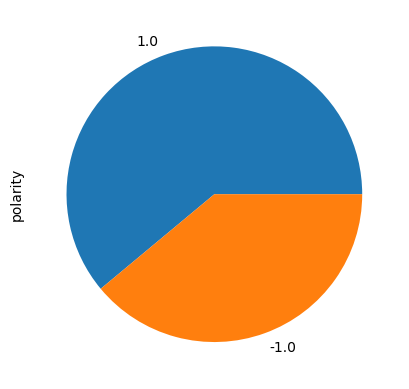

In [67]:
sentilex.polarity.value_counts().plot(kind='pie');

## Top positive words

In [68]:
sentilex.sort_values('valence', ascending=False).head(10)

,valence,polarity
term_str,,
superb,9.538122,1.0
immense,8.766363,1.0
dramatic,8.746213,1.0
premier,8.705049,1.0
sites,8.684018,1.0
parcel,8.574004,1.0
amazing,8.550957,1.0
exquisite,8.404364,1.0
sumptuous,8.351992,1.0


## Top negative words

In [69]:
sentilex.sort_values('valence', ascending=True).head(10)

,valence,polarity
term_str,,
everyday,-11.407852,-1.0
dull,-11.179734,-1.0
bland,-10.981340,-1.0
watery,-10.969476,-1.0
dilute,-10.709060,-1.0
mealy,-10.665602,-1.0
pickled,-10.605543,-1.0
weedy,-10.477362,-1.0
strange,-10.241220,-1.0


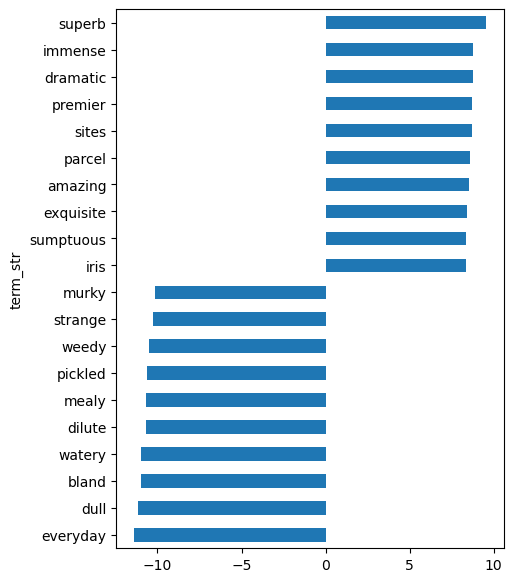

In [70]:
wpos = sentilex.valence.sort_values().tail(10)
wneg = sentilex.valence.sort_values().head(10)
pd.concat([wneg,wpos]).plot.barh(figsize=(5,7));

# Save

In [71]:
sentilex .to_csv(f"{data_out}/{prefix}/{prefix}-NB_SALEX.csv", index=True)
training_docs.to_csv(f"{data_out}/{prefix}/{prefix}-DOCS_training.csv", index=True)
testing_docs.to_csv(f"{data_out}/{prefix}/{prefix}-DOCS_testing.csv", index=True)
training_bow.to_csv(f"{data_out}/{prefix}/{prefix}-BOW_training.csv", index=True)
testing_bow.to_csv(f"{data_out}/{prefix}/{prefix}-BOW_testing.csv", index=True)
vocab.to_csv(f"{data_out}/{prefix}/{prefix}-VOCAB.csv", index=True)